# 1. Install Dependencies and Setup

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remove dodgy images

In [55]:
import cv2
import imghdr
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

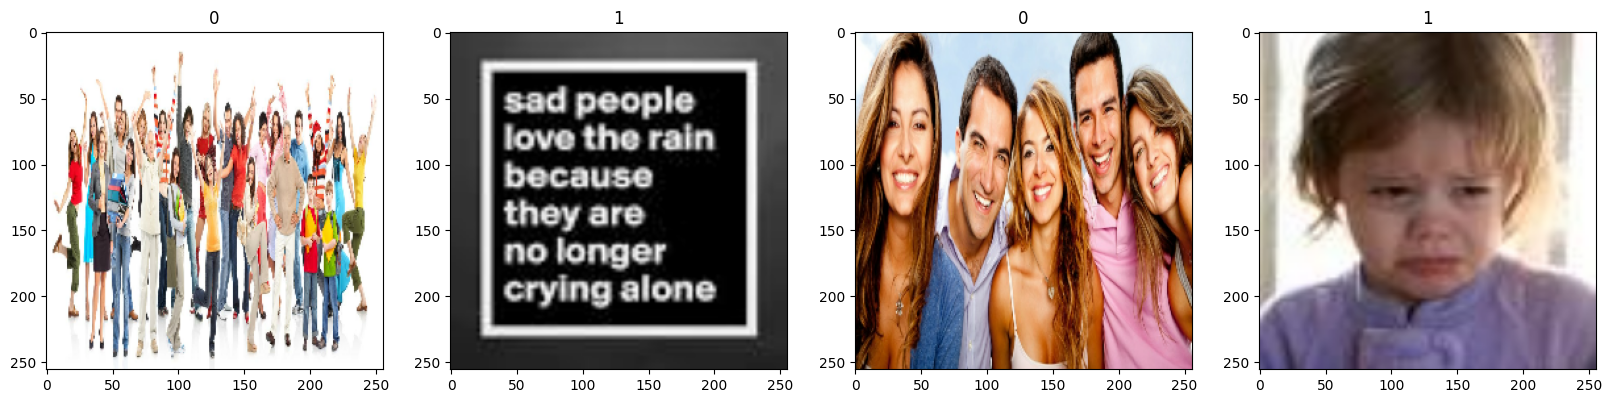

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.9607843 , 1.        , 0.972549  ],
          [0.9611213 , 1.        , 0.972549  ],
          [0.96265316, 1.        , 0.972549  ],
          ...,
          [0.9775735 , 0.9775735 , 0.9775735 ],
          [0.9959559 , 0.9959559 , 0.9959559 ],
          [1.        , 1.        , 1.        ]],
 
         [[0.9607843 , 1.        , 0.972549  ],
          [0.9611213 , 1.        , 0.97260696],
          [0.96265316, 1.        , 0.97287023],
          ...,
          [0.978266  , 0.978266  , 0.978266  ],
          [0.99414706, 0.99414706, 0.99414706],
          [0.9976409 , 0.9976409 , 0.9976409 ]],
 
         [[0.9607843 , 1.        , 0.972549  ],
          [0.9611213 , 1.        , 0.97287023],
          [0.96265316, 1.        , 0.9743303 ],
          ...,
          [0.9814135 , 0.9814135 , 0.9814135 ],
          [0.9859253 , 0.9859253 , 0.9859253 ],
          [0.9869179 , 0.9869179 , 0.9869179 ]],
 
         ...,
 
         [[0.89666057, 0.9102941 , 0.9084253 ],
          [0.90404

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [56]:
model = Sequential()
warnings.filterwarnings("ignore", category=UserWarning)

In [57]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 768ms/step - accuracy: 0.4676 - loss: 1.5354 - val_accuracy: 0.5312 - val_loss: 0.6606
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 595ms/step - accuracy: 0.5721 - loss: 0.6630 - val_accuracy: 0.4531 - val_loss: 0.6981
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - accuracy: 0.5790 - loss: 0.6065 - val_accuracy: 0.7656 - val_loss: 0.6020
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 554ms/step - accuracy: 0.7179 - loss: 0.6122 - val_accuracy: 0.7188 - val_loss: 0.5238
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.7530 - loss: 0.5666 - val_accuracy: 0.7969 - val_loss: 0.5006
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.8444 - loss: 0.4187 - val_accuracy: 0.8594 - val_loss: 0.3199
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 426ms/step - accuracy: 0.8381 - loss: 0.3852 - val_accuracy: 0.8906 - val_loss: 0.2983
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.8255 - loss: 0.4083 - val_accuracy: 0.7969 - val_loss:

# 8. Plot Performance

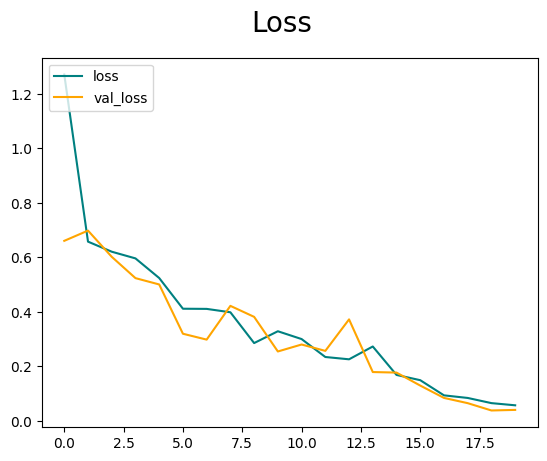

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

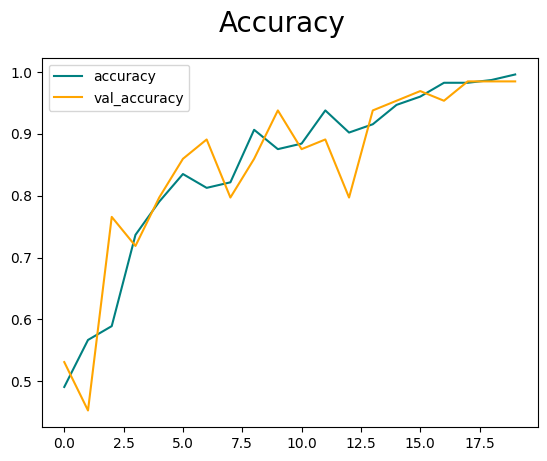

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

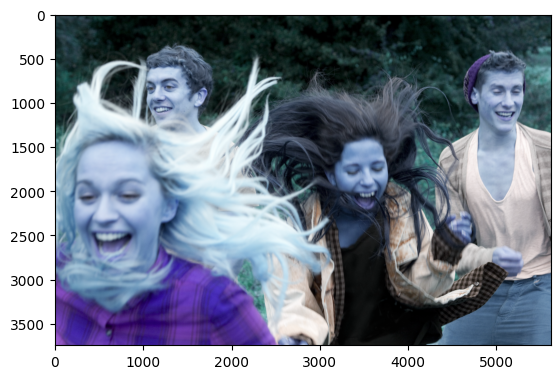

In [36]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

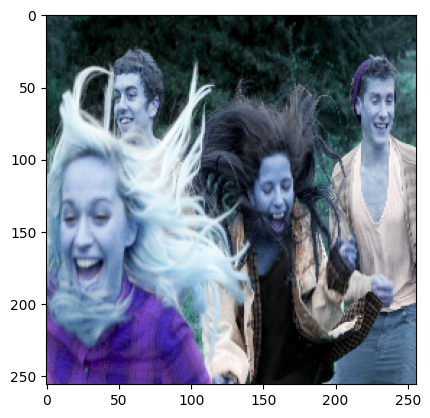

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [39]:
yhat

array([[0.63034]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.keras'))

In [43]:
new_model = load_model(os.path.join('models','imageclassifier.keras'))

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


array([[0.63034]], dtype=float32)

In [45]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


In [46]:
if yhatnew > 0.5:
    print(f'predicted class is Sad')
else:
    print(f'predicted class is Happy')

predicted class is Sad
